# Foundations of Data Mining: Assignment 2

- Students: JiYang Li(0975662),  Nan Yang(0963123)
- Group No: 28

In [1]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
#HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
InteractiveShell.ast_node_interactivity = "none"

In [2]:
# This is a temporary read-only OpenML key.
oml.config.apikey = '6455db467b30b2fdf1d17d27e33fc28c'

## Kernel selection

In [26]:
# import dataset
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)

### Intuition 

Since the SVM requires features value approximately in a same scale, we check the feature scale of this dataset.

In [90]:
print("The maxium and minimum value of feature 0 are %.4f, %.4f" %( X[:,0].max(),X[:,0].min()))
print("The maxium and minimum value of feature 1 are %.4f, %.4f" %( X[:,1].max(),X[:,1].min()))

The maxium and minimum value of feature 0 are 5.2262, -1.6829
The maxium and minimum value of feature 1 are 7.0631, -1.6436


As can be seen from the maximum and minimum values of features, they are almost in the same scale. Hence, We can start training directly. Firstly, the default hyperparameters are used for each kernel.

In [27]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

for kernel in ['linear', 'poly', 'rbf']:
    clf = svm.SVC(kernel=kernel)
    scores = cross_val_score(clf, X, y, scoring="roc_auc", cv=10)
    print("%s SVM classifier: " % kernel)
    print("score (AUC) on test set: {:.4f}".format(scores.mean()))

linear SVM classifier: 
score (AUC) on test set: 0.9936
poly SVM classifier: 
score (AUC) on test set: 0.9929
rbf SVM classifier: 
score (AUC) on test set: 0.9768


In [82]:
def plot_svm(clf, X, y, ax):  
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=10, edgecolors='k', c='w', zorder=10,marker='^')
    ax.scatter(X[:, 0], X[:, 1], c=y,s=5, zorder=10, cmap=plt.cm.bwr)

        
    ax.axis('tight')
    # Define axis length
    x_min = X[:,0].min()*1.1
    x_max = X[:,0].max()*1.1
    y_min = X[:,1].min()*1.1
    y_max = X[:,1].max()*1.1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
 
    #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.bwr, alpha=0.1)
    ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    ax.set_xticks(())
    ax.set_yticks(())
    

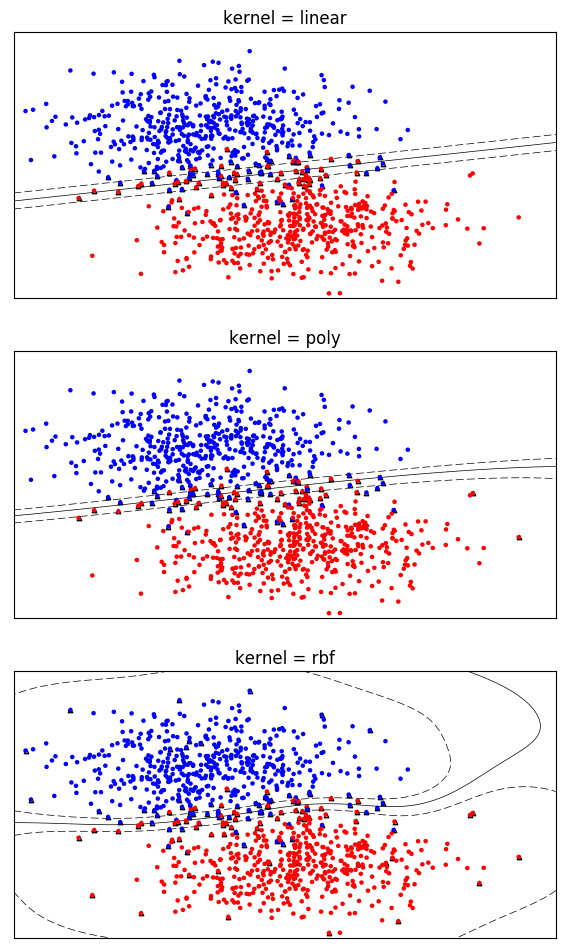

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(7,12))

for kernel, ax in zip(['linear', 'poly', 'rbf'],axes):    
    # fit the model
    clf = svm.SVC(kernel=kernel)
    clf.fit(X, y)
    ax.set_title('kernel = %s' % kernel)
    # plot scatter graph
    plot_svm(clf, X, y, ax)
plt.show()

From the figures above, we can observe that rbf and poly kernel lead to more support vectors than linear kernel does. However, linear kernel leads to a better accuracy. We can also observe that the margin is smaller by using rbf kernel which may leads to overfitting. For this dataset, it seems linear kernel is better than other kernels due to less overfitting.

### Tune hyperparameters

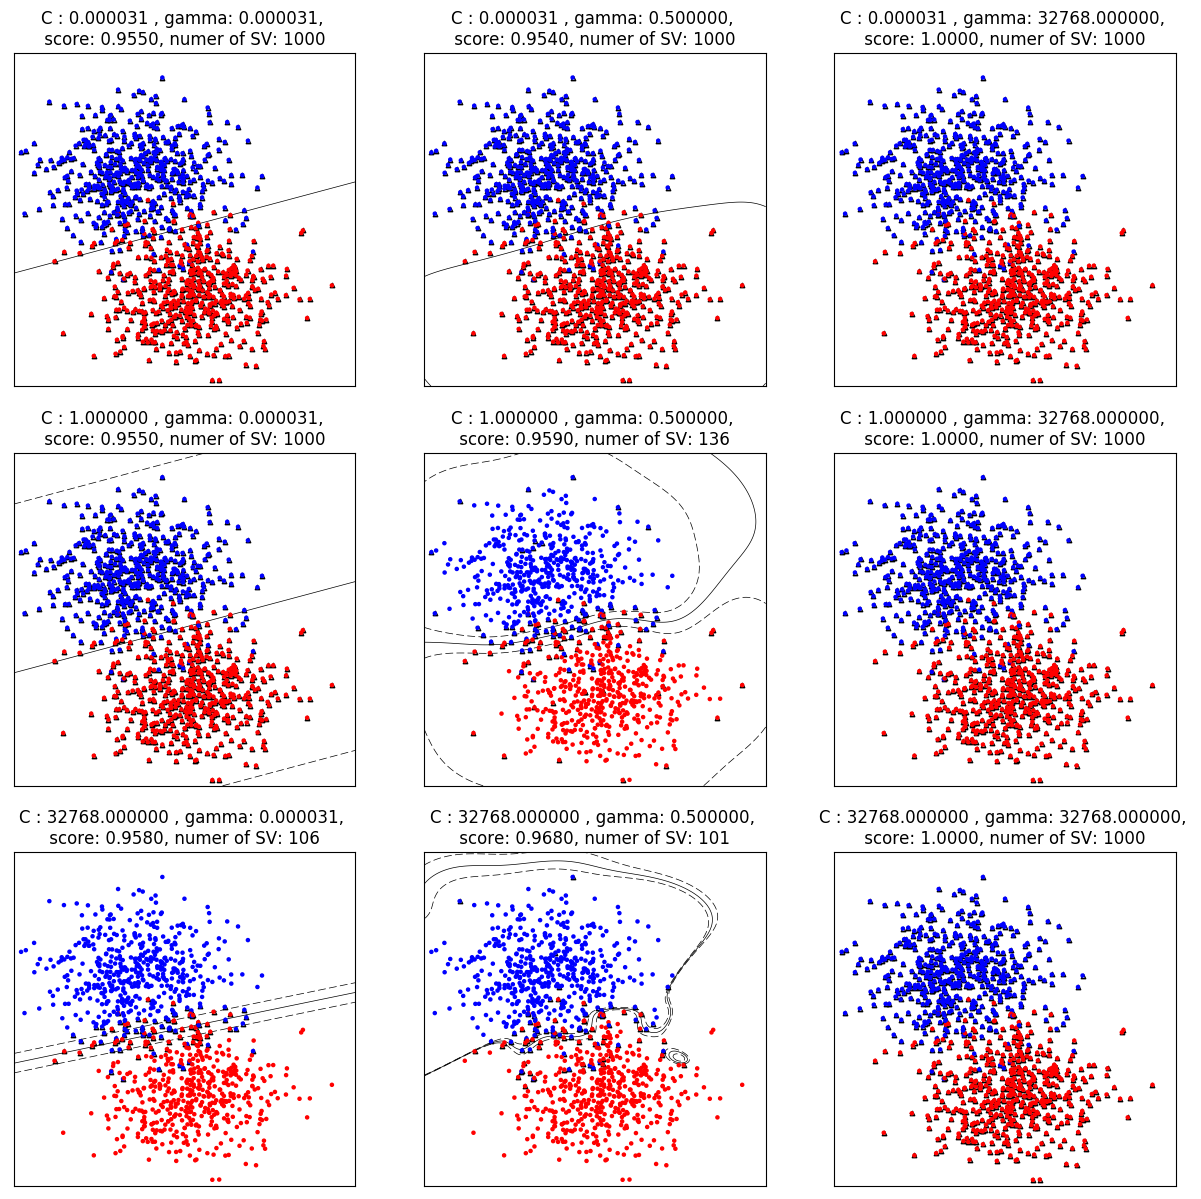

In [42]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_auc_score

fig, axes = plt.subplots(3, 3, figsize=(15,15))

# set up parameters
Cs= [2**(-15),1,2**(15)]
gammas = [2**(-15),1/2,2**(15)]
axIndex = 0
scores = []
supp_vectors = []
for C in Cs:
    for gamma in gammas:
        clf = svm.SVC(random_state=0,C=C,gamma=gamma)
        # fit dataset
        clf.fit(X, y)
        score = roc_auc_score(y,clf.predict(X))
        # extract the number of SV
        n_sv = len(clf.support_vectors_[:])
        axes[axIndex/3,axIndex%3].set_title('C : %f , gamma: %f, \n score: %.4f, numer of SV: %d ' % (C, gamma,score, n_sv))
        # plot scatter graph
        plot_svm(clf, X, y, axes[axIndex/3,axIndex%3])
        axIndex = axIndex + 1
plt.show()

In [43]:
print("The number of samples in this dataset is %d "% len(X))

The number of samples in this dataset is 1000 


It can be observed from graphs that the model try to fit every data point(overfit) and have more support vectors when gamma is very large. The decision boudaries tend to be more linear when gamma is small. 

When C is small, the number of support vector is increased while with smaller weigh. When C is large, the number of support vectors are reduced while each of support vectors have stronger influence.

In conclusion, we observe that high gamma may lead to ovefitting while high C can reduce overfitting. 

Now we investigate into more fine-grained change of hyperparamters.

### Fine tuning

In [44]:
para_list = [ 2**(-12+i) for i in range(24)]
clf = svm.SVC(random_state=0)
#set up parameters
param_grid = {'C':para_list,'gamma':para_list}
#grid search
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring ="roc_auc" )
grid_search.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048], 'gamma': [0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [22]:
print(" Best C(log2): %s" %(np.log2(grid_search.best_params_['C'])))
print(" Best gamma(log2): %s" %(np.log2(grid_search.best_params_['gamma'])))
print(" Best score :%.4f "% grid_search.best_score_)

 Best C(log2): 9.0
 Best gamma(log2): -11.0
 Best score :0.9938 


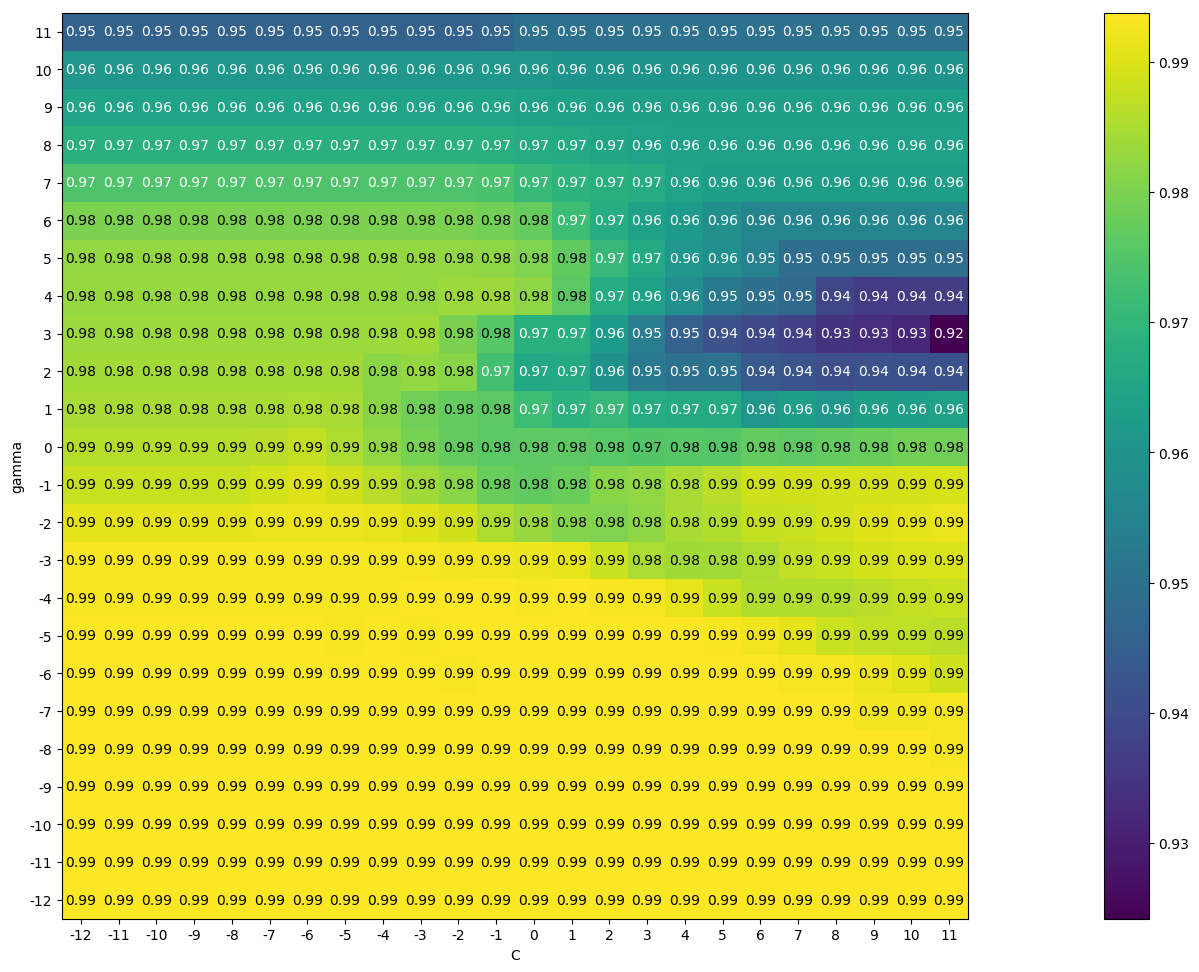

In [56]:
# Visualization
result = pd.DataFrame(grid_search.cv_results_)
scores = np.array(result.mean_test_score).reshape(len(param_grid['C']),len(param_grid['gamma']))
# set figure size
plt.figure(figsize=(35,12))
# plot the mean cross-validation scores
heatmap  = mglearn.tools.heatmap(np.transpose(scores), ylabel='gamma', yticklabels=np.log2(param_grid['gamma']).astype(int),
                     xlabel='C', xticklabels=np.log2(param_grid['C']).astype(int), cmap="viridis",fmt="%.2f");
plt.colorbar(heatmap)

From the visualization above we can see that when the gamma is smaller than 2^-2, the accuracy achieves sufficient good values.
However, when the gamma is significantly large, the accuracy is relative low. From last question we know that this is because of overfitting. 

The accuracy is relative poor when c is very large and gamma is larger than 1. The reason of this poor accuracy is still overfitting. Here we verify it by plot the scatter graph with a model traning by the poorest comibination of c = 2^11 and gamma = 2^3.

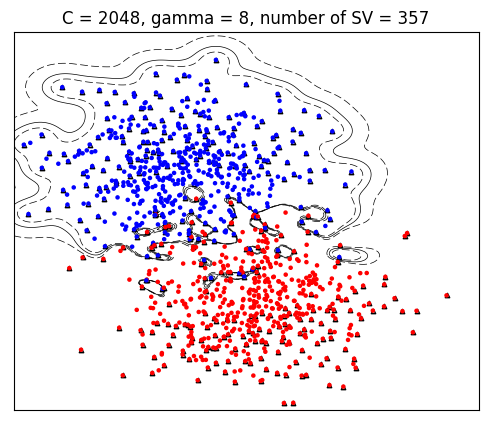

0.995


In [92]:
fig, axes = plt.subplots(1, 1, figsize=(6,5))
clf = svm.SVC(C=2**11,gamma =2**3)
# fit data
clf.fit(X, y)
# extract the number of SV
n_sv = len(clf.support_vectors_[:])
axes.set_title('C = %d, gamma = %d, number of SV = %d'%(2**11,2**3,n_sv))
plot_svm(clf, X, y, axes)
plt.show()
score = roc_auc_score(y,clf.predict(X))
print(score)

It can be seem from graph above, the model trys to get every point right and introduces many support vectors. And the prediction on the full set is 0.995, which is overfitting. 
The next step we plot scatter graph for the best combinations which c= 2^9 and gamma = 2^-11

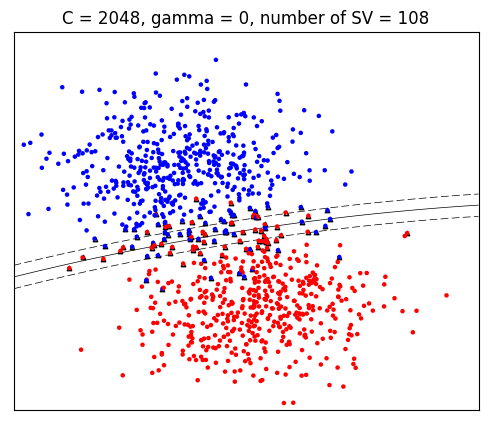

0.958


In [97]:
fig, axes = plt.subplots(1, 1, figsize=(6,5))
# use SVC
clf = svm.SVC(C=2**9,gamma =2**-11)
# fit data
clf.fit(X, y)
# extract the number of SV
n_sv = len(clf.support_vectors_[:])
axes.set_title('C = %d, gamma = %d, number of SV = %d'%(2**9,2**-11,n_sv))
plot_svm(clf, X, y, axes)
plt.show()
# score on full set
score = roc_auc_score(y,clf.predict(X))
print(score)

As can be seen from figure above, the decision boundary is almost linear which is comparable to our intuition that linear model might be the best kernel for this dataset.

## Robots and SVMs

### optimize hyperparameters

In [99]:
from sklearn.model_selection import train_test_split

# Download Robot data
robot_data = oml.datasets.get_dataset(1497) 
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute); 

# split up dataset
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0, stratify = y,train_size = 0.8, test_size=0.2)

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

# try linear,rbf and poly kernels
kernels = ['linear','rbf','poly']
best_model = {k: None for k in kernels}
# hyperparameter settings
param_grids = [{'C': expon(scale=100)}, {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}, {'C': expon(scale=100),'degree':list(range(2,11))}]

for kernel,param_grid in zip(kernels, param_grids):
    # random search
    random_search = RandomizedSearchCV(svm.SVC(random_state=0,kernel = kernel), param_distributions=param_grid,
                                       n_iter=10,n_jobs =-1, cv =10)
    random_search.fit(X_train, y_train)
    best_model[kernel] = random_search.best_estimator_
    print('%s : Best parameters: %s'% (kernel,random_search.best_params_))
    print('%s : Best score: %s'% (kernel,random_search.best_score_))

linear : Best parameters: {'C': 86.248953787740078}
linear : Best score: 0.730751604033
rbf : Best parameters: {'C': 30.56875874639794, 'gamma': 0.029758847923151185}
rbf : Best score: 0.924381301558
poly : Best parameters: {'C': 1.0714069297893736, 'degree': 3}
poly : Best score: 0.917506874427


We can observe that here rbf outperforms two other kernels. The best hyperparameters combination is $C=53.3$ and $gamma = 0.015$

### Nested cross validation

In [102]:
param_grids = [{'C': expon(scale=100)}, {'C': expon(scale=100), 
              'gamma': expon(scale=.1)}, {'C': expon(scale=100),'degree':list(range(2,11))}]
# nested cross validation
for kernel,param_grid in zip(['linear','rbf', 'poly'],param_grids):
    # inner: random search
    random_search = RandomizedSearchCV(svm.SVC(random_state=0,kernel =kernel), param_distributions=param_grid,
                                           n_iter=10, cv =3,n_jobs = -1)
    # outer: cross validation
    scores = cross_val_score(random_search, X, y, cv=5)

    mean_score = scores.mean()
    print("The mean score with nested cross validation with kernel %s is: %.3f"% (kernel,mean_score))

The mean score with nested cross validation with kernel linear is: 0.700
The mean score with nested cross validation with kernel rbf is: 0.854
The mean score with nested cross validation with kernel poly is: 0.835


From the result of the nested cross validation, we can conform that rbf is the best kernel for training this dataset. As we know that Non nested cross validation use the same dataset to train and evaluate the model performance, therefore,information may “leak” into the model. However, the nested cross validation use separated test set to evaluate model performance and average the scores, which provide a lower but more persuasive score.

Now we train the best estimators of each kernel with training data set and then test them with the separated test set.

In [103]:
for kernel in kernels:
    clf = best_model[kernel]
    clf.fit(X_train, y_train)
    print("%s: The accurracy for the separated test set is : %.3f" %(kernel,clf.score(X_test,y_test)))

linear: The accurracy for the separated test set is : 0.741
rbf: The accurracy for the separated test set is : 0.935
poly: The accurracy for the separated test set is : 0.927


The test results above are comparable with the random search results. Rbf kernel is the best option for this dataset, which achieves acurracy 0.935 with optimized hyperparameters. In practices, We think kernel is the essential parameter to be tuned. For example, in this exerciese we observe a huge difference performance between linear kernel and rbf kernel. Besides that, a fine-grained grid search is required for searching the best set of hyperparameters. For rbf kernel, to avoid overfitting or underfitting, it is important to tune C and gamma parameters. 


## A benchmark study

In [3]:
import math

datasets = [37, 470, 1120, 1464, 1471]
checkNan =[]
shape=[]
for i in datasets:
    data = oml.datasets.get_dataset(i) 
    X, y = data.get_data(target=data.default_target_attribute);
    # if there is nan?
    checkNan.append(any(np.isnan(X.flatten())))
    # shape of dataset
    shape.append(X.shape)
    
data = {'NaN': checkNan, 'Shape': shape}
display(pd.DataFrame(data,index =datasets))

,NaN,Shape
37,False,"(768, 8)"
470,True,"(672, 9)"
1120,False,"(19020, 10)"
1464,False,"(748, 4)"
1471,False,"(14980, 14)"


It can be observed from the datasets that there is NaN in dataset 470, and the features of each dataset are not in the same scale. Hence, adding a value to each missing spot and scaling feature values are reuqired to be done before modeling. Besides that, the feature reduction tecniques PCA is also adopted to reduce the similarity between features. Here we pipline each stages of preprocessing and classification with defualt value for three classifiers.

In [5]:
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 

# set up a pipeline
pipe = Pipeline([("Imputer", Imputer(strategy='median')),
                    ('reduce_dim', PCA()),                     
                     ("scaler", StandardScaler()), 
                     ("clf", KNeighborsClassifier())]) 
# paramters setting
param_grid = [{'clf':[KNeighborsClassifier()],
               'Imputer':[Imputer(strategy='median')],'reduce_dim': [PCA()],"scaler": [StandardScaler()]}, 
              {'clf':[RandomForestClassifier()],
               'Imputer':[Imputer(strategy='median')],'reduce_dim': [PCA()], "scaler": [StandardScaler()]}, 
              {'clf':[GaussianNB()],
              'Imputer':[Imputer(strategy='median')],'reduce_dim': [PCA()], "scaler": [StandardScaler()]}]

In [6]:
grid_result =[]
for dataset in datasets:
    data = oml.datasets.get_dataset(dataset) 
    X, y = data.get_data(target=data.default_target_attribute)       
    grid = GridSearchCV(pipe, param_grid,scoring ="roc_auc",n_jobs = -1,cv=10)
    grid.fit(X,y)
    grid_result.append(grid.cv_results_['mean_test_score'])
display(pd.DataFrame(grid_result,columns = ['KNeighborsClassifier','RandomForestClassifier','GaussianNB'],index=datasets))

,KNeighborsClassifier,RandomForestClassifier,GaussianNB
37,0.77,0.79,0.81
470,0.57,0.53,0.66
1120,0.89,0.91,0.79
1464,0.53,0.56,0.48
1471,0.50,0.53,0.42


From the result showed above, we can observe that GaussianNB is the best option for dataset 37 and 470. RandomForest is the best option for dataset 1120,1464 and 1471.

The number of neighbors is a very essential parameter of knn classifer. The defualt setting seems does not play the best for those datasets.

Now we optimize the hyperparameters for each classifer.

In [7]:
# max features
max_f = [0.1,0.3,0.5,0.7,0.9,1]
# number of estimators
n_est = [2, 4, 8, 16, 32, 64, 128]
# number of neighbors
n_neg = [1, 3, 5, 7, 9, 11, 33]

# paramters setting, including hyperparameters
param_grid = [{'clf':[KNeighborsClassifier()],
               'Imputer':[Imputer(strategy='median')],'reduce_dim': [PCA()],"scaler": [StandardScaler()],
               'clf__n_neighbors':n_neg,}, 
              {'clf':[RandomForestClassifier()],
               'Imputer':[Imputer(strategy='median')],'reduce_dim': [PCA()], "scaler": [StandardScaler()],
               'clf__max_features': max_f,'clf__n_estimators':n_est,}, 
              {'clf':[GaussianNB()],
              'Imputer':[Imputer(strategy='median')],'reduce_dim': [PCA()], "scaler": [StandardScaler()]}]

In [8]:
best_para =[]
best_score=[]
# grid search for all datasets
for dataset in datasets:
    data = oml.datasets.get_dataset(dataset) 
    X, y = data.get_data(target=data.default_target_attribute)       
    grid = GridSearchCV(pipe, param_grid,scoring ="roc_auc",n_jobs = -1,cv=10)
    grid.fit(X,y)
    # record down the best parameters and scores
    best_para.append(grid.best_params_)
    best_score.append(grid.best_score_)

In [9]:
best_clf = [a['clf'] for a in best_para ]
best_array = np.array((datasets+best_clf + best_score)).reshape(3,-1).T
print(best_array)
#pd.DataFrame(best_array,columns = ['best classifier','best score'],index = datasets)

[[37
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=64, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
  0.82919051964624879]
 [470 GaussianNB(priors=None) 0.65701205246042194]
 [1120
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=128, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
  0.9277435440468631]
 [1464
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1

From the result showed above we can see that now randomforest is still the best classifier for dataset 1120, 1471 and 1464, and outperform GaussianNB on dataset 37. GaussianNB is still the best option for dataset 470. 

From the two questions above we can observe that GaussianNB classifier has good performance in those low dimensional datasets and it require almost no tunning.  Randomforest classifer can achieve good performance in many different datasets while requires for more tunings.

## Gaussian Processes

In [20]:
ram_prices = pd.read_csv('data/ram_price.csv')

In [21]:
from sklearn.model_selection import train_test_split

# split up dataset
train = ram_prices.query("date < 2000")
test = ram_prices.query("date >= 2000")
X_train,y_train = train.date.reshape(-1,1),train.price.reshape(-1,1)
X_test, y_test = test.date.reshape(-1,1),test.price.reshape(-1,1)

Firstly, several other classifiers are tried.

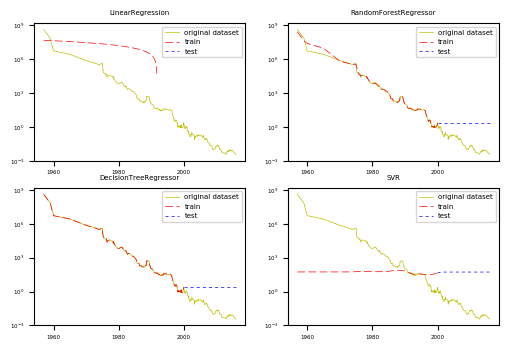

In [36]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# try LinearRegression, RandomForestRegressor, DecisionTreeRegressor and SVR with default settings
fig_num =221
algorithms = [LinearRegression, RandomForestRegressor, DecisionTreeRegressor, SVR]
train_s =[]
test_s = []
for al in algorithms:
    # plot original dataset
    plt.subplot(fig_num)
    plt.title(al.__name__,fontsize=5)
    plt.semilogy(ram_prices.date, ram_prices.price,color = 'y',label = 'original dataset')
    # fit data
    clf = al()
    clf.fit(X_train,y_train)
    
    # plot
    plt.semilogy(X_train, clf.predict(X_train), color = 'r' , label = 'train')
    plt.semilogy(X_test, clf.predict(X_test),color = 'b' , label = 'test')
   
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.legend(fontsize=5)
    
    fig_num = fig_num + 1
    # record down train score and test score
    train_s.append(clf.score(X_train,y_train))
    test_s.append(clf.score(X_test,y_test))
    
d = np.array(train_s+test_s).reshape(2,-1).T

In [19]:
display(pd.DataFrame(d,columns=['Train','Test'],index = ['LR','RF','DT','SVR']))

,Train,Test
LR,1.21e-01,-5.20e+15
RF,8.96e-01,-2.54e+01
DT,1.00e+00,-5.08e+01
SVR,-6.88e-03,-2.97e+04


From the result above we can see that Randomforest and Decisiontree fit train set well. And we could see that the $R^2$ score of Decisiontree is 1, which means it is overfitting the train data. So reasonably it will fail on the test set as well as other regressors. LinearRegression fails to fit both train set and test set cause data is decreasing exponentially so it cannot predict well. SVR behaves worse than LinearRegression here.

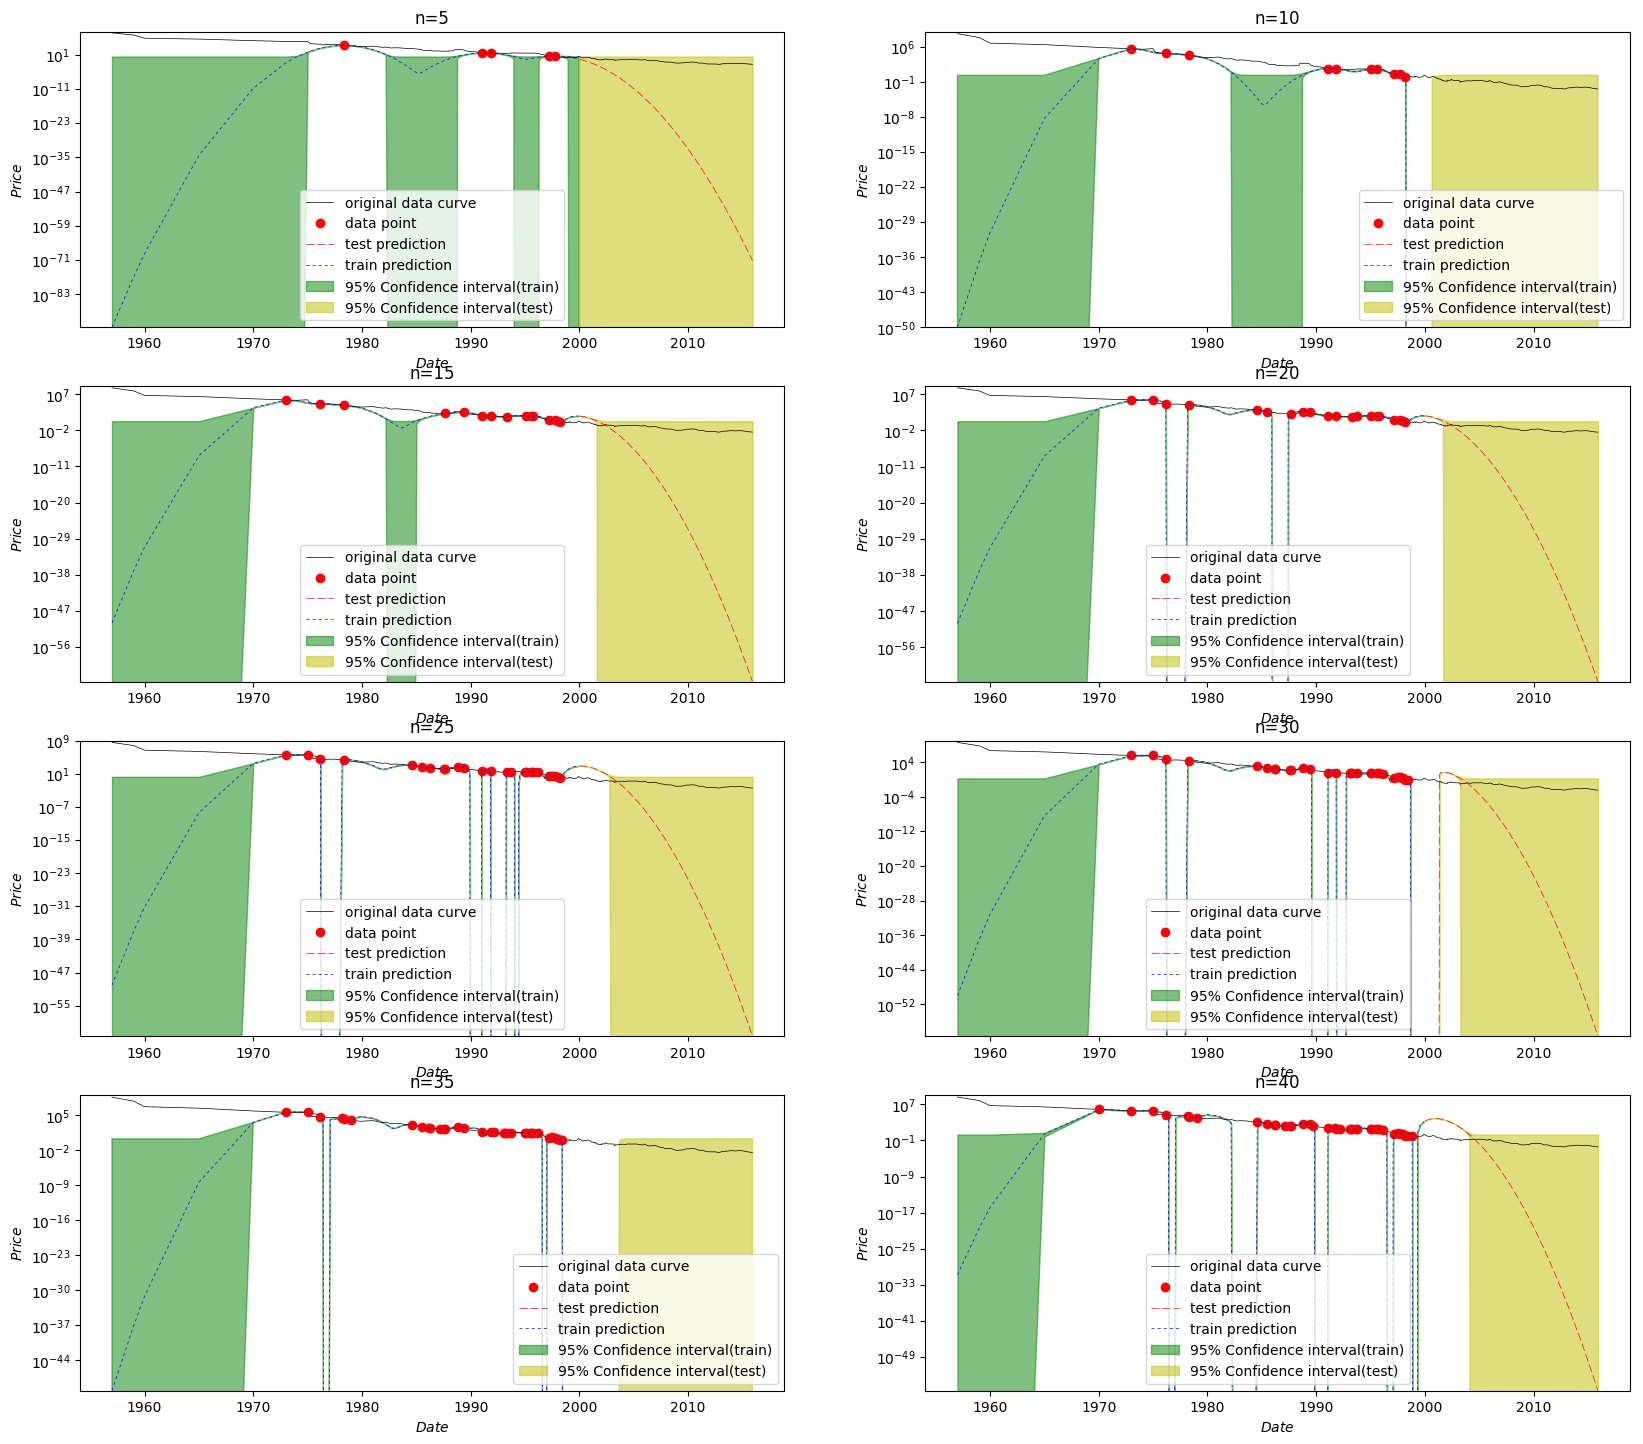

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils import shuffle

n_fig = 8
fig, axes = plt.subplots(int(n_fig/2), int(n_fig/4), figsize=(20,18))
axIndex = 0
# a list contains number of data points
search_list = [ (i+1)*5 for i in list(range(40))]
trainScore =[]
testScore = []

for n_dataPoint in search_list:
    # sample data points 
    x_s, y_s = shuffle(X_train, y_train, random_state=0, n_samples=n_dataPoint)
   
    # Instanciate a Gaussian Process model
    gp = GaussianProcessRegressor()

    # Fit data
    gp.fit(x_s, y_s)

    # Make the prediction on both test set and train set
    test_pred, sigma_test = gp.predict(X_test, return_std=True)
    train_pred,sigma_train = gp.predict(X_train, return_std=True)
    test_pred = test_pred.flatten()
    train_pred = train_pred.flatten()
    
    # store the scores
    trainScore.append(gp.score(X_train,y_train))
    testScore.append(gp.score(X_test,y_test))
    
    # plot 8 figures
    if(n_dataPoint<= n_fig*5):
        ax = axes[axIndex/2,axIndex%2]
        ax.set_title("n={:d}".format(n_dataPoint))
        ax.plot(ram_prices.date, ram_prices.price,color = 'black',label= 'original data curve')
        ax.plot(x_s, y_s, 'ro',label = 'data point')
        ax.plot(X_test, test_pred, 'r', label='test prediction')
        ax.plot(X_train, train_pred, 'b',label='train prediction')

        ax.fill_between(X_train.flatten(), train_pred - 1.9600 * sigma_train, train_pred + 1.9600 * sigma_train, 
                        alpha=0.5, label="95% Confidence interval(train)",color ='green')
        ax.fill_between(X_test.flatten(), test_pred - 1.9600 * sigma_test, test_pred + 1.9600 * sigma_test, 
                        alpha=0.5, label="95% Confidence interval(test)",color ='y')
        ax.set_yscale('log')
        ax.set_xlabel('$Date$')
        ax.set_ylabel('$Price$')
        ax.set_ylim(0, 1e9)
        ax.legend()
        axIndex = axIndex+1

From above figures we can see that the confidence interval, which is the area of green and yellow regions, for predicting train set decreases as the increase of number of data points being trained. Comparing the train set and test set we could draw a conclusiton that the confidence interval of train set decreases more than test set. So model becomes more confident for prediction when number of trainning samples increases. 

Now we plot the figure score vs number of data points 

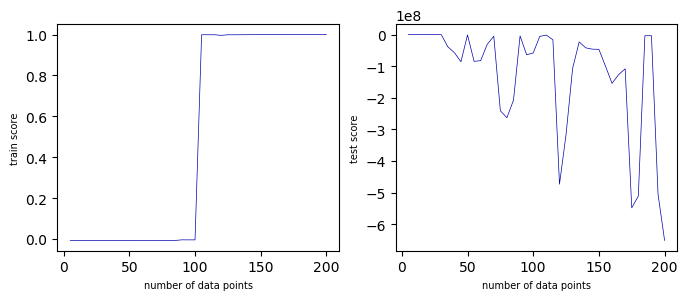

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
axes[0].set_xlabel('number of data points',fontsize =7)
axes[0].set_ylabel('train score',fontsize =7)
axes[0].plot(list(search_list),trainScore,label = 'train score')


axes[1].set_xlabel('number of data points',fontsize =7)
axes[1].set_ylabel('test score',fontsize =7)
axes[1].plot(list(search_list),testScore)


When the number of trainning data achieves 100, $R^2$ score on train set jumped abruptly and became relative high. The $R^2$ score on test set fluctuates a lot as the number of trainning data increases, and the scores remain negative. However, the score could be relatively high when the number of trainning data is small, this is because the simple model could result in underfitting. In conclusion, the behavior of GaussianProcessRegressor on test set varies a lot. 

Now We first use grid search to find the optimized model and then train it with full train set.

The score for train set is : 0.756 
The score for test set is : 0.854 


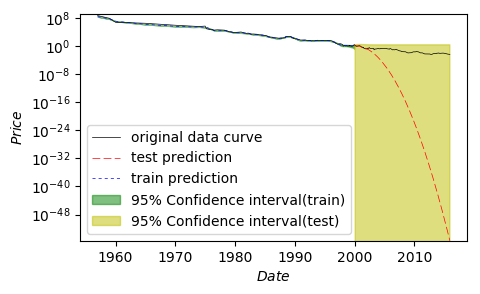

In [39]:
# Instanciate a Gaussian Process model
from sklearn.model_selection import GridSearchCV 
from sklearn.gaussian_process import GaussianProcessRegressor
# hyperparamter settings
param_grid = {'alpha':[1e-12,1e-10,1e-8,1e-6,1e-4,1e-2,1,1e2,1e3],'n_restarts_optimizer':list(range(10))}
# gaussian
gp = GaussianProcessRegressor()
# grid search
grid_search = GridSearchCV(gp, param_grid, cv=10)
#Fit data
grid_search.fit(X_train, y_train)

# estract the best estimators
gp = grid_search.best_estimator_
gp.fit(X_train, y_train)

# Make the prediction on both test set and train set
test_pred, sigma_test = gp.predict(X_test, return_std=True)
train_pred,sigma_train = gp.predict(X_train, return_std=True)
test_pred = test_pred.flatten()
train_pred = train_pred.flatten()
print("The score for train set is : %.3f "% gp.score(X_train,y_train))
print("The score for test set is : %.3f "% gp.score(X_test,y_test))

plt.figure(figsize=(5,3))
plt.plot(ram_prices.date, ram_prices.price,color = 'black',label= 'original data curve')
#ax.semilogy(X_train, y_train.ravel(), 'ro',label = 'data point')
plt.plot(X_test, test_pred, 'r', label='test prediction')
plt.plot(X_train, train_pred, 'b',label='train prediction')
plt.fill_between(X_train.flatten(), train_pred - 1.9600 * sigma_train, train_pred + 1.9600 * sigma_train, 
                    alpha=0.5, label="95% Confidence interval(train)",color ='green')
plt.fill_between(X_test.flatten(), test_pred - 1.9600 * sigma_test, test_pred + 1.9600 * sigma_test, 
                    alpha=0.5, label="95% Confidence interval(test)",color ='y')
plt.yscale('log')
plt.xlabel('$Date$')
plt.ylabel('$Price$')
plt.ylim(0, 1e9)
plt.legend()

The score for predicting train set and test set are good. The model is nearly 100% confident in its prediction on train set since the area of green region is very small, while the area of confidence interval in predicting test set remains large. 
Comparing with other algorithms, the $R^2$ scores of train set is higher then LinearRegression and SVR but lower than RandomForestRegressor and DecisionTreeRegressor. Since it behaves better on test set than all of other regressors, GaussianProcessRegressor is the one fit the exponentially changing data best.

### A mini-data mining challenge

In [5]:
# download dataset
task = oml.tasks.get_task(145677)
data = oml.datasets.get_dataset(task.dataset_id)
X, y = data.get_data(target=data.default_target_attribute)
print(X.shape)

(3751, 1776)


This dataset is high-dimensional with 1776 features. Therefore, two strategies can be explored.
- Classifiers that are good at dealing with high-dimensional dataset, such as SVM and randomforest
- Preprocessing: feature selection or dimensionality reduction

Firstly, we try SVM classifier and optimize the parameters with random search.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from scipy.stats import expon

# try two kernel: rbf and poly
kernels = ['rbf','poly']
best_model = {k: None for k in kernels}
param_grids = [{'C': expon(scale=100), 
              'gamma': expon(scale=.1)}, {'C': expon(scale=100),'degree':list(range(2,11))}]
for kernel,param_grid in zip(kernels, param_grids):
    random_search = RandomizedSearchCV(svm.SVC(random_state=0,kernel = kernel), param_distributions=param_grid,
                                       n_iter=10,n_jobs =-1, cv =5,scoring ="roc_auc")
    random_search.fit(X, y)
    best_model[kernel] = random_search.best_estimator_
    print('%s : Best parameters(AUC): %s'% (kernel,random_search.best_params_))
    print('%s : Best score(AUC): %s'% (kernel,random_search.best_score_))

rbf : Best parameters(AUC): {'C': 57.867218398792751, 'gamma': 0.0050688534075839214}
rbf : Best score(AUC): 0.840462589154
poly : Best parameters(AUC): {'C': 24.738648570755281, 'degree': 3}
poly : Best score(AUC): 0.767649654162


By purely processing RandomSearchCV on SVM above we observe that the best score provided is 0.84 with kernel rbf. 

Next, We try randomforest classifier.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 

param_grids = {'max_features' :list(np.arange(0.1, 1, 5)), 'n_estimators': [256,512,1024,2048]}
grid = GridSearchCV(RandomForestClassifier(random_state=0,criterion="entropy",bootstrap = True), param_grids, n_jobs =-1,scoring ="roc_auc")
grid.fit(X, y)
# record the best estimator
rf_best = grid.best_estimator_
print('Best parameters: %s'% (grid.best_params_))
print('Best score: %s'% (grid.best_score_))

task = oml.tasks.get_task(145677)
print("Running..")
# run the best estimator
run = oml.runs.run_task(task, rf_best)
print("Publishing run")
myrun = run.publish()
print("RF on %s: http://www.openml.org/r/%d" % (data.name, myrun.run_id))

Best parameters: {'max_features': 0.10000000000000001, 'n_estimators': 2048}
Best score: 0.877210215766
Running..
Publishing run
RF on Bioresponse: http://www.openml.org/r/1849830


By processing GridSearchCV on RandomForestClassifier above we find the best score is 0.8835, which is a little lower than the best score o.887 on OpenML server. Basically, our score can be further promoted a little bit by increasing the number of estimators. However, the training time will significantly increase at the same time, which is not efficient compared to the gain. 

Now we try to select important features with randomforest classifer, and use SVM to classify the selected dataset. To avoid information leakage, we make a pipeline for the stages. 

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

select = SelectFromModel(
    RandomForestClassifier(n_estimators=256, random_state=0),
    threshold='median')
# get the best SVM estimator
clf = best_model['rbf']
# make a pipeline
pipe = Pipeline([
    ('feature_select', select),
    ('classifier', clf)
])
score = cross_val_score(pipe, X, y, cv=10, n_jobs=-1, scoring="roc_auc")
print('cross validation score: %.5f'%score.mean())

cross validation score: 0.84766


A reasonable result is obtained by modeling with feature selection and SVM classifier. It failed to beat randomforest classifier that we tried before. However, the accuracy is slightly increased compared to using SVM classifier without feature selection. So when we met such data with very high dimension (features) and want to use SVM, it's better to simplify the data first.

Besides, the traning time of this model is less compared to that of our best model(RF).

Now we try to reduce the dimensions of the dataset with PCA. 

In [6]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

pca = PCA(n_components=0.9)
# get the best SVM estimator
clf = best_model['rbf']
# make a pipeline
pipe = Pipeline([
    ('feature_reduce', pca),
    ('classifier', clf)
])
score = cross_val_score(pipe, X, y, cv=10, n_jobs=-1, scoring="roc_auc")
print('cross validation score: %.5f'%score.mean())

cross validation score: 0.85170


Although this model still does not beat randomforest classifer, it promotes the accuracy of SVM classifier further since it reduces the similarity among features by projection. So from above two processes, we can conclude that PCA works better on this data than simply select features from model. Noteworthy, n_components is also a hyperparameter that can be optimized. Limited by the computation resource, we only set it as 0.9 here which however might not be the optimized value for this dataset.

In conclusion, randomforest classifer with a large number of estimator is the best solution for this dataset.